# Estimate errors in flux calculations

In [1]:
# load modules 

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
from funcs import *
import os 
from xgcm import Grid

In [2]:
Lcoarse = 50e3

In [3]:
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
#Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')

In [4]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [5]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [4]:
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})

In [5]:
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})

NameError: name 'UpCp' is not defined

In [6]:
def flux_reconstruct(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)

    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [7]:
frb = flux_reconstruct(diff_tensor.Kcorr, fluxT, gradT)
flux_rec_buoy_AT = flux_reconstruct(diff_tensor.ATcorr , fluxT, gradT) 
flux_rec_buoy_ST = flux_reconstruct(diff_tensor.STcorr , fluxT, gradT) 

In [ ]:
# flux divergence



In [8]:
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

# Some plots

In [10]:
Xcoarse = T_coarse.XCcoarse.data
Ycoarse = T_coarse.YCcoarse.data
Z = T_coarse.Z.data

Ypcol = np.append(Ycoarse, Ycoarse[-1]+Lcoarse)-Lcoarse/2
Xpcol = np.append(Xcoarse, Xcoarse[-1]+Lcoarse)-Lcoarse/2
Zpcol = np.append(Z, Z[-1])

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


Text(0, 0.5, 'Eddy Temp Flux ($ m ^oC/s$)')

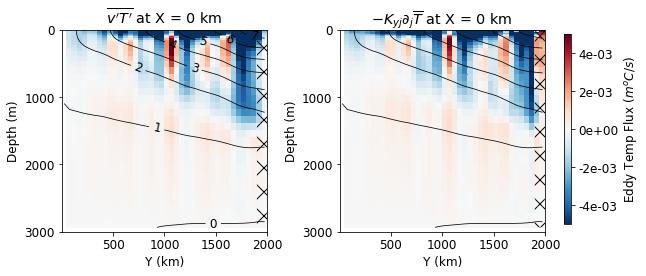

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.))

###
ax[0].pcolormesh(Ypcol/1e3, Zpcol, T_coarse.VpTp.where(Trac_coarse.hFacCcoarse==1).sel(XCcoarse=0, method='nearest'),
                   vmin=-0.005, vmax=0.005, cmap='RdBu_r', rasterized=True)
ax[0].pcolor(Ypcol/1e3, Zpcol, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(XCcoarse=0, method='nearest'),
              hatch='X', alpha=0)
im2 = ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=0, method='nearest'), 
                levels=np.linspace(0,8,9), colors='k', linewidths=.75, rasterized=True)
ax[0].set_title(r'$\overline{v^\prime T^\prime}$ at X = 0 km')
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xticks([500, 1000, 1500, 2000])
ax[0].set_yticks([-3000,-2000, -1000,0])
ax[0].set_yticklabels([3000,2000, 1000,0])

fmt = {}
strs = [0,1,2,3,4,5,6,7,8]
for l, s in zip(im2.levels, strs):
    fmt[l] = str(s)
ax[0].clabel(im2, im2.levels[::1], fmt=fmt, colors='k')


###
im = ax[1].pcolormesh(Ypcol/1e3, Zpcol, frb.VpCp.where(Trac_coarse.hFacCcoarse==1).sel(XCcoarse=0, method='nearest'),
                   vmin=-0.005, vmax=0.005, cmap='RdBu_r', rasterized=True)
ax[1].pcolor(Ypcol/1e3, Zpcol, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(XCcoarse=0, method='nearest'),
              hatch='X', alpha=0)
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=0, method='nearest'), 
                levels=np.linspace(0,8,9), colors='k', linewidths=.75, rasterized=True)
ax[1].set_title(r'$-K_{yj}\partial_j\overline{T}$ at X = 0 km')
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Depth (m)')
ax[1].set_xticks([500, 1000, 1500, 2000])
ax[1].set_yticks([-3000,-2000, -1000,0])
ax[1].set_yticklabels([3000,2000, 1000,0])

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.66])
fig.colorbar(im, cax=cbar_ax,format='%.0e',)
cbar_ax.set_ylabel('Eddy Temp Flux ($ m ^oC/s$)')
#plt.savefig('fig3a.pdf', dpi=200,bbox_inches='tight')


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


Text(0, 0.5, 'Eddy Temp Flux ($ m ^oC/s$)')

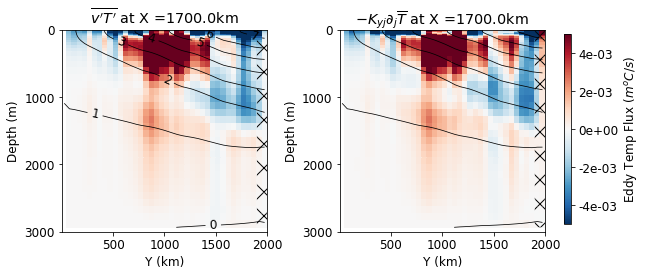

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.))

xloc = 1700e3
###
ax[0].pcolormesh(Ypcol/1e3, Zpcol, T_coarse.VpTp.where(Trac_coarse.hFacCcoarse==1).sel(XCcoarse=xloc, method='nearest'),
                   vmin=-0.005, vmax=0.005, cmap='RdBu_r', rasterized=True)
ax[0].pcolor(Ypcol/1e3, Zpcol, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(XCcoarse=xloc, method='nearest'),
              hatch='X', alpha=0)
im2 = ax[0].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=xloc, method='nearest'), 
                levels=np.linspace(0,8,9), colors='k', linewidths=.75, rasterized=True)
ax[0].set_title(r'$\overline{v^\prime T^\prime}$ at X =' + str(xloc/1e3) + 'km')
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xticks([500, 1000, 1500, 2000])
ax[0].set_yticks([-3000,-2000, -1000,0])
ax[0].set_yticklabels([3000,2000, 1000,0])

fmt = {}
strs = [0,1,2,3,4,5,6,7,8]
for l, s in zip(im2.levels, strs):
    fmt[l] = str(s)
ax[0].clabel(im2, im2.levels[::1], fmt=fmt, colors='k')


###
im = ax[1].pcolormesh(Ypcol/1e3, Zpcol, frb.VpCp.where(Trac_coarse.hFacCcoarse==1).sel(XCcoarse=xloc, method='nearest'),
                   vmin=-0.005, vmax=0.005, cmap='RdBu_r', rasterized=True)
ax[1].pcolor(Ypcol/1e3, Zpcol, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(XCcoarse=0, method='nearest'),
              hatch='X', alpha=0)
ax[1].contour(Ycoarse/1e3, Z, T_coarse['T'].sel(XCcoarse=xloc, method='nearest'), 
                levels=np.linspace(0,8,9), colors='k', linewidths=.75, rasterized=True)
ax[1].set_title(r'$-K_{yj}\partial_j\overline{T}$ at X =' + str(xloc/1e3) + 'km')
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Depth (m)')
ax[1].set_xticks([500, 1000, 1500, 2000])
ax[1].set_yticks([-3000,-2000, -1000,0])
ax[1].set_yticklabels([3000,2000, 1000,0])

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.66])
fig.colorbar(im, cax=cbar_ax,format='%.0e',)
cbar_ax.set_ylabel('Eddy Temp Flux ($ m ^oC/s$)')
#plt.savefig('fig3a.pdf', dpi=200,bbox_inches='tight')


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


Text(0, 0.5, 'Eddy Temp Flux ($ m ^oC/s$)')

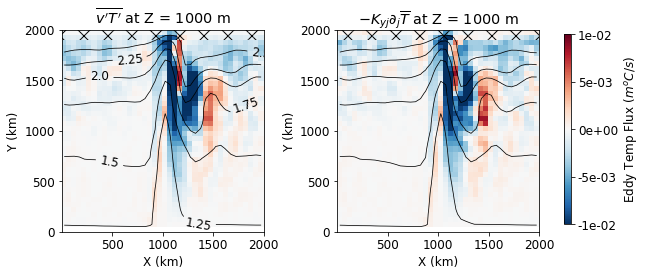

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.))
###
ax[0].pcolormesh(Xpcol/1e3, Ypcol/1e3, T_coarse.VpTp.where(Trac_coarse.hFacCcoarse==1).sel(Z=-1000, method='nearest'),
                   vmin=-0.01, vmax=0.01, cmap='RdBu_r', rasterized=True)
ax[0].pcolor(Xpcol/1e3, Ypcol/1e3, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(Z=-1000, method='nearest'),
              hatch='x', alpha=0)
im2 = ax[0].contour(Xcoarse/1e3, Ycoarse/1e3, T_coarse['T'].sel(Z=-1000, method='nearest'), 
                levels=np.linspace(1,3,9), colors='k', linewidths=0.75, rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_title(r'$\overline{v^\prime T^\prime}$ at Z = 1000 m')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_xticks([500, 1000, 1500, 2000])
ax[0].set_yticks([0, 500, 1000, 1500, 2000])

fmt = {}
strs = np.linspace(1,3,9)
for l, s in zip(im2.levels, strs):
    fmt[l] = str(s)
ax[0].clabel(im2, im2.levels[::1], fmt=fmt, colors='k')

###
im= ax[1].pcolormesh(Xpcol/1e3, Ypcol/1e3, frb.VpCp.where(Trac_coarse.hFacCcoarse==1).sel(Z=-1000, method='nearest'), 
                   vmin=-0.01, vmax=0.01, cmap='RdBu_r', rasterized=True)
ax[1].pcolor(Xpcol/1e3, Ypcol/1e3, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(Z=-1000, method='nearest'),
              hatch='x', alpha=0)
ax[1].contour(Xcoarse/1e3, Ycoarse/1e3, T_coarse['T'].sel(Z=-1000, method='nearest'), 
                levels=np.linspace(1,3,9), colors='k', linewidths=0.75, rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_title(r'$-K_{yj}\partial_j\overline{T}$ at Z = 1000 m')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
ax[1].set_xticks([500, 1000, 1500, 2000])
ax[1].set_yticks([0, 500, 1000, 1500, 2000])

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.66])
fig.colorbar(im, cax=cbar_ax,format='%.0e',)
cbar_ax.set_ylabel('Eddy Temp Flux ($ m ^oC/s$)')
#plt.savefig('fig3b.pdf', dpi=200,bbox_inches='tight')


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'rasterized'
  
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: The following kwargs were not used by contour: 'rasterized'


Text(0, 0.5, 'Eddy Temp Flux ($ m ^oC/s$)')

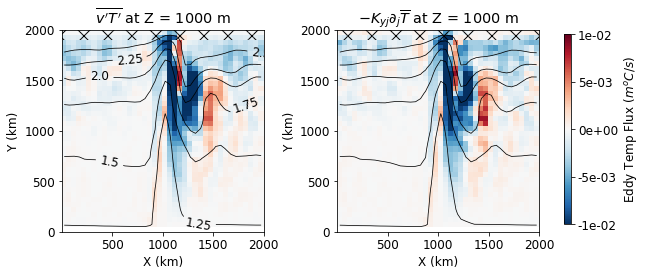

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.))
###
ax[0].pcolormesh(Xpcol/1e3, Ypcol/1e3, T_coarse.VpTp.where(T_coarse.hFacCcoarse==1).sel(Z=-1000, method='nearest'),
                   vmin=-0.01, vmax=0.01, cmap='RdBu_r', rasterized=True)
ax[0].pcolor(Xpcol/1e3, Ypcol/1e3, T_coarse.hFacCcoarse.where(T_coarse.YCcoarse>=1900e3).sel(Z=-1000, method='nearest'),
              hatch='x', alpha=0)
im2 = ax[0].contour(Xcoarse/1e3, Ycoarse/1e3, T_coarse['T'].sel(Z=-1000, method='nearest'), 
                levels=np.linspace(1,3,9), colors='k', linewidths=0.75, rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_title(r'$\overline{v^\prime T^\prime}$ at Z = 1000 m')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_xticks([500, 1000, 1500, 2000])
ax[0].set_yticks([0, 500, 1000, 1500, 2000])

fmt = {}
strs = np.linspace(1,3,9)
for l, s in zip(im2.levels, strs):
    fmt[l] = str(s)
ax[0].clabel(im2, im2.levels[::1], fmt=fmt, colors='k')

###
im= ax[1].pcolormesh(Xpcol/1e3, Ypcol/1e3, frb.VpCp.where(T_coarse.hFacCcoarse==1).sel(Z=-1000, method='nearest'), 
                   vmin=-0.01, vmax=0.01, cmap='RdBu_r', rasterized=True)
ax[1].pcolor(Xpcol/1e3, Ypcol/1e3, T_coarse.hFacCcoarse.where(T_coarse.YCcoarse>=1900e3).sel(Z=-1000, method='nearest'),
              hatch='x', alpha=0)
ax[1].contour(Xcoarse/1e3, Ycoarse/1e3, T_coarse['T'].sel(Z=-1000, method='nearest'), 
                levels=np.linspace(1,3,9), colors='k', linewidths=0.75, rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_title(r'$-K_{yj}\partial_j\overline{T}$ at Z = 1000 m')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
ax[1].set_xticks([500, 1000, 1500, 2000])
ax[1].set_yticks([0, 500, 1000, 1500, 2000])

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.66])
fig.colorbar(im, cax=cbar_ax,format='%.0e',)
cbar_ax.set_ylabel('Eddy Temp Flux ($ m ^oC/s$)')
#plt.savefig('fig3b.pdf', dpi=200,bbox_inches='tight')


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


Text(0, 0.5, 'Eddy Temp Flux ($ m ^oC/s$)')

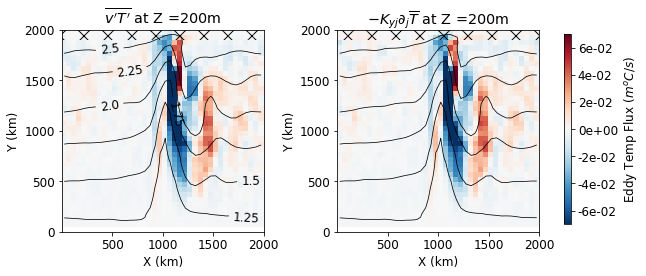

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.))
zloc = -200
###
ax[0].pcolormesh(Xpcol/1e3, Ypcol/1e3, T_coarse.VpTp.where(Trac_coarse.hFacCcoarse==1).sel(Z=zloc, method='nearest'),
                   vmin=-0.07, vmax=0.07, cmap='RdBu_r', rasterized=True)
ax[0].pcolor(Xpcol/1e3, Ypcol/1e3, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(Z=zloc, method='nearest'),
              hatch='x', alpha=0)
im2 = ax[0].contour(Xcoarse/1e3, Ycoarse/1e3, T_coarse['T'].sel(Z=zloc, method='nearest'), 
                levels=np.linspace(1,8,9), colors='k', linewidths=0.75, rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_title(r'$\overline{v^\prime T^\prime}$ at Z =' + str(-zloc) + 'm')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_xticks([500, 1000, 1500, 2000])
ax[0].set_yticks([0, 500, 1000, 1500, 2000])

fmt = {}
strs = np.linspace(1,3,9)
for l, s in zip(im2.levels, strs):
    fmt[l] = str(s)
ax[0].clabel(im2, im2.levels[::1], fmt=fmt, colors='k')

###
im= ax[1].pcolormesh(Xpcol/1e3, Ypcol/1e3, frb.VpCp.where(Trac_coarse.hFacCcoarse==1).sel(Z=zloc, method='nearest'), 
                   vmin=-0.07, vmax=0.07, cmap='RdBu_r', rasterized=True)
ax[1].pcolor(Xpcol/1e3, Ypcol/1e3, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(Z=zloc, method='nearest'),
              hatch='x', alpha=0)
ax[1].contour(Xcoarse/1e3, Ycoarse/1e3, T_coarse['T'].sel(Z=zloc, method='nearest'), 
                levels=np.linspace(1,8,9), colors='k', linewidths=0.75, rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_title(r'$-K_{yj}\partial_j\overline{T}$ at Z =' + str(-zloc) + 'm')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
ax[1].set_xticks([500, 1000, 1500, 2000])
ax[1].set_yticks([0, 500, 1000, 1500, 2000])

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.66])
fig.colorbar(im, cax=cbar_ax,format='%.0e',)
cbar_ax.set_ylabel('Eddy Temp Flux ($ m ^oC/s$)')
#plt.savefig('fig3b.pdf', dpi=200,bbox_inches='tight')


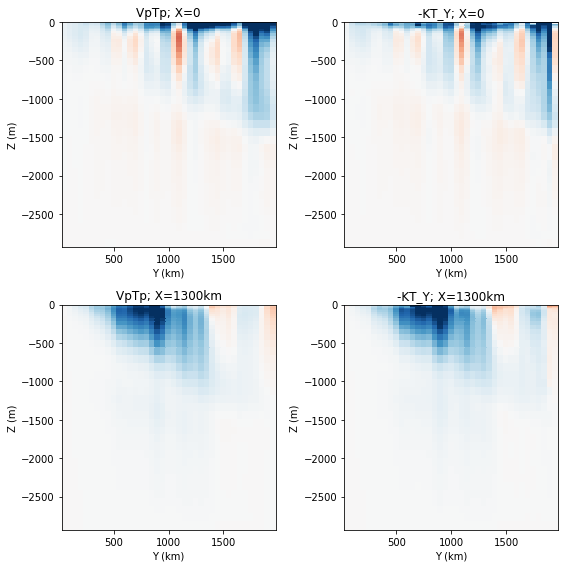

In [153]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCcoarse=0, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; X=0')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, flux_rec_buoy.VpCp.sel(XCcoarse=0, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; X=0')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCcoarse=1200e3, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; X=1300km')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, flux_rec_buoy.VpCp.sel(XCcoarse=1200e3, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; X=1300km')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()

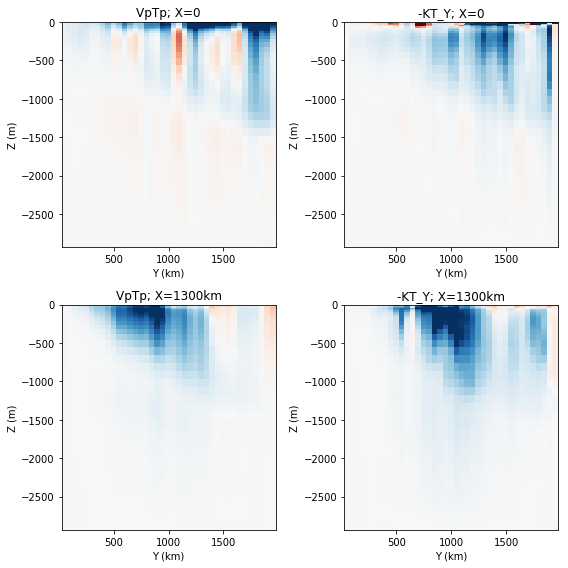

In [158]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCcoarse=0, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; X=0')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, flux_rec_buoy_AT.VpCp.sel(XCcoarse=0, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; X=0')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCcoarse=1200e3, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; X=1300km')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, flux_rec_buoy_AT.VpCp.sel(XCcoarse=1200e3, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; X=1300km')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()

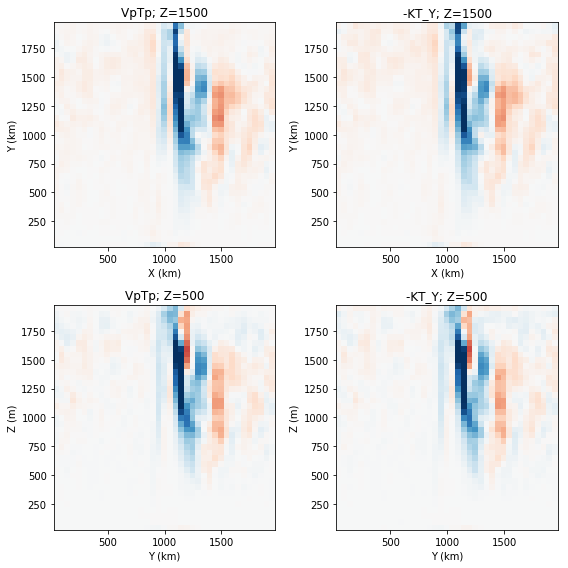

In [154]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy.VpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy.VpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()
#plt.savefig('mer_flux_reconstruction_Z.pdf')

In [13]:
flux_rec_buoy_AT

NameError: name 'flux_rec_buoy_AT' is not defined

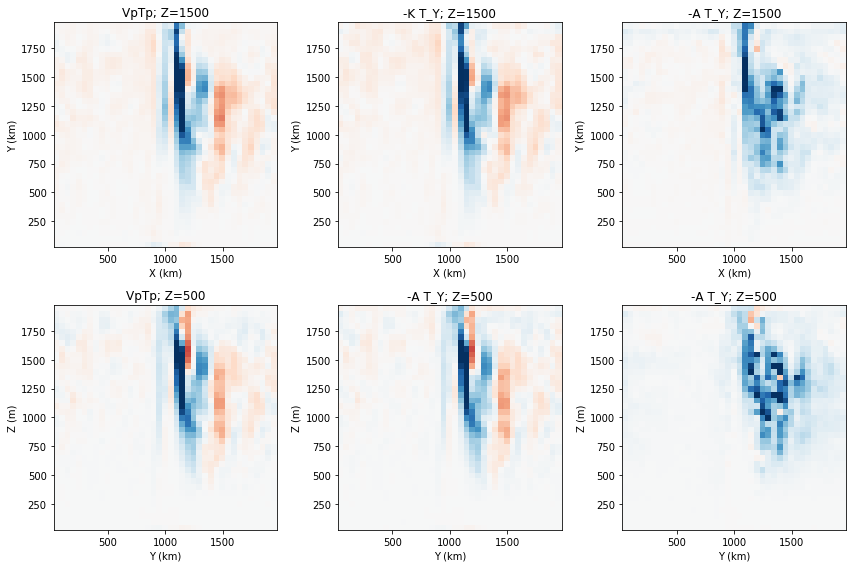

In [167]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy.VpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-K T_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.VpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,2].set_title('-A T_Y; Z=1500')
ax[0,2].set_xlabel('X (km)')
ax[0,2].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy.VpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-A T_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.VpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,2].set_title('-A T_Y; Z=500')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')

plt.tight_layout()
#plt.savefig('mer_flux_reconstruction_2Zs.pdf')

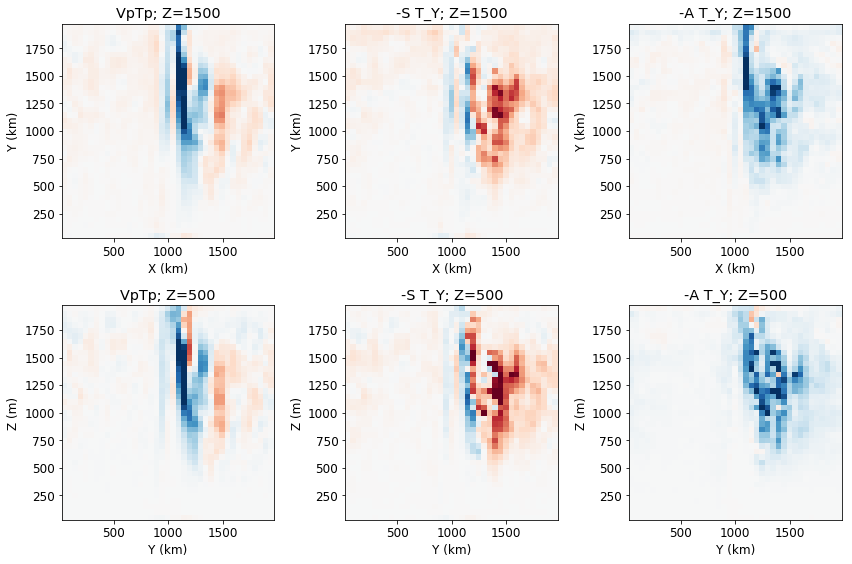

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_ST.VpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-S T_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.VpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,2].set_title('-A T_Y; Z=1500')
ax[0,2].set_xlabel('X (km)')
ax[0,2].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_ST.VpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-S T_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.VpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,2].set_title('-A T_Y; Z=500')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')

plt.tight_layout()

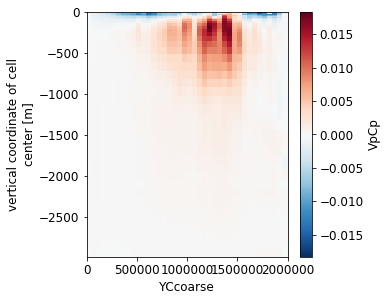

In [13]:
flux_rec_buoy_ST.VpCp.mean('XCcoarse').plot()

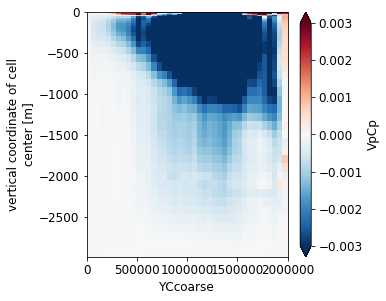

In [18]:
flux_rec_buoy_AT.VpCp.mean('XCcoarse').plot(vmin=-3e-3)

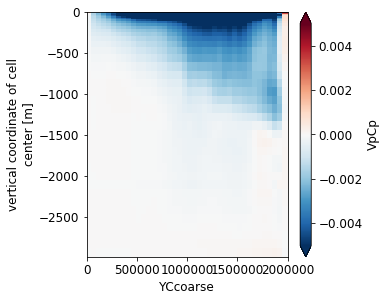

In [17]:
(flux_rec_buoy_AT + flux_rec_buoy_ST).VpCp.mean('XCcoarse').plot(vmin=-0.005)

In [ ]:
fl

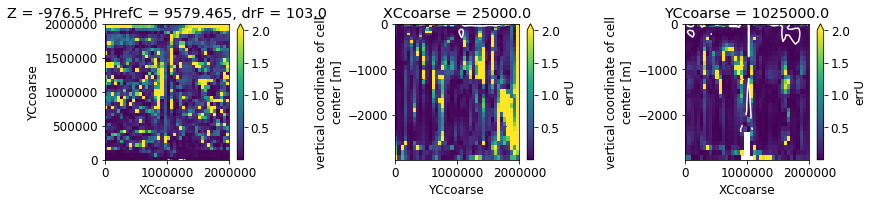

In [21]:
# maps of errors
plt.figure(figsize=(12,3))

plt.subplot(131)
frb.errU.sel(Z=-1000, method='nearest').plot(vmax=2)
#plt.contour(Ycoarse, Z,diff_tensor.eigvalsST.where(T_coarse.hFacCcoarse==1.).sel(
#                    XCcoarse=xloc, method='nearest').isel(ii=1), 
#             levels=[0], colors='k')
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    Z=-1000, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')


plt.subplot(132)
frb.errU.sel(XCcoarse=0, method='nearest').plot(vmax=2)
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    XCcoarse=0, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')


plt.subplot(133)
frb.errU.sel(YCcoarse=1000e3, method='nearest').plot(vmax=2)
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    YCcoarse=1000e3, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')
plt.tight_layout()

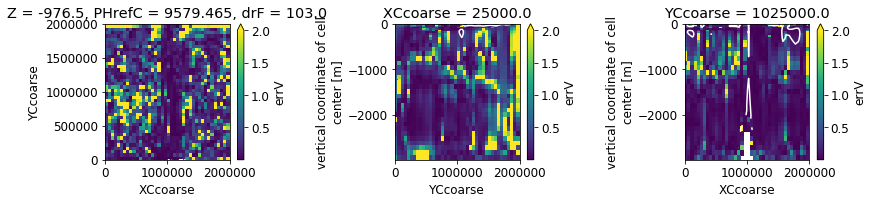

In [21]:
# maps of errors
plt.figure(figsize=(12,3))

plt.subplot(131)
frb.errV.sel(Z=-1000, method='nearest').plot(vmax=2)
#plt.contour(Ycoarse, Z,diff_tensor.eigvalsST.where(T_coarse.hFacCcoarse==1.).sel(
#                    XCcoarse=xloc, method='nearest').isel(ii=1), 
#             levels=[0], colors='k')
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    Z=-1000, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')


plt.subplot(132)
frb.errV.sel(XCcoarse=0, method='nearest').plot(vmax=2)
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    XCcoarse=0, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')


plt.subplot(133)
frb.errV.sel(YCcoarse=1000e3, method='nearest').plot(vmax=2)
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    YCcoarse=1000e3, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')
plt.tight_layout()

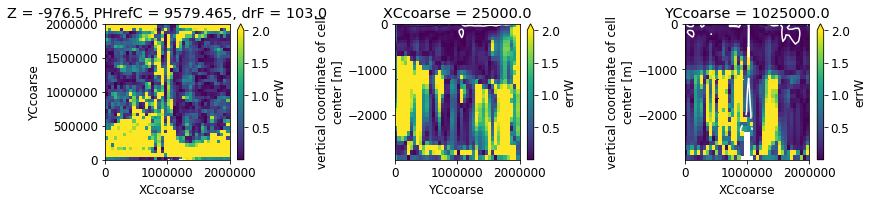

In [23]:
# maps of errors
plt.figure(figsize=(12,3))

plt.subplot(131)
frb.errW.sel(Z=-1000, method='nearest').plot(vmax=2)
#plt.contour(Ycoarse, Z,diff_tensor.eigvalsST.where(T_coarse.hFacCcoarse==1.).sel(
#                    XCcoarse=xloc, method='nearest').isel(ii=1), 
#             levels=[0], colors='k')
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    Z=-1000, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')


plt.subplot(132)
frb.errW.sel(XCcoarse=0, method='nearest').plot(vmax=2)
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    XCcoarse=0, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')


plt.subplot(133)
frb.errW.sel(YCcoarse=1000e3, method='nearest').plot(vmax=2)
plt.contour(Ycoarse, Z,diff_tensor.Kcorr.where(T_coarse.hFacCcoarse==1.).sel(
                    YCcoarse=1000e3, method='nearest').isel(i=1, j=1), 
             levels=[0], colors='w')
plt.tight_layout()